## Deep Research

One of the classic cross-business Agentic use cases! This is huge.

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">A Deep Research agent is broadly applicable to any business area, and to your own day-to-day activities. You can make use of this yourself!
            </span>
        </td>
    </tr>
</table>

In [1]:
from agents import Agent, WebSearchTool, trace, Runner, gen_trace_id, function_tool
from agents.model_settings import ModelSettings
from pydantic import BaseModel
from dotenv import load_dotenv
import asyncio
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
from typing import Dict
from IPython.display import display, Markdown
from tavily import TavilyClient
from agents.extensions.visualization import draw_graph


In [2]:
load_dotenv(override=True)

True

## OpenAI Hosted Tools

OpenAI Agents SDK includes the following hosted tools:

The `WebSearchTool` lets an agent search the web.  
The `FileSearchTool` allows retrieving information from your OpenAI Vector Stores.  
The `ComputerTool` allows automating computer use tasks like taking screenshots and clicking.

### Important note - API charge of WebSearchTool

This is costing me 2.5 cents per call for OpenAI WebSearchTool. That can add up to $2-$3 for the next 2 labs. We'll use low cost Search tools with other platforms, so feel free to skip running this if the cost is a concern.

Costs are here: https://platform.openai.com/docs/pricing#web-search

In [3]:
@function_tool
def search_web(query: str) -> str:
    """
    Searches the web using Tavily API and returns the top result.
    Args:
        query (str): The search query.
    Returns:
        str: The title and URL of the top search result.
    """
    load_dotenv(".envrc")
    api_key = os.getenv("TAVILY_API_KEY")
    client = TavilyClient(api_key=api_key)
    results = client.search(query=query, limit=3)
    return str(results)

In [4]:
INSTRUCTIONS = "You are a research assistant. Given a search term, you search the web for that term and \
produce a concise summary of the results. The summary must 2-3 paragraphs and less than 300 \
words. Capture the main points. Write succintly, no need to have complete sentences or good \
grammar. This will be consumed by someone synthesizing a report, so it's vital you capture the \
essence and ignore any fluff. Do not include any additional commentary other than the summary itself."

search_agent = Agent(
    name="Search agent",
    instructions=INSTRUCTIONS,
    tools=[search_web],
    # tools=[WebSearchTool(search_context_size="low")],
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"),
)

In [5]:
message = "Latest latest updates of the IRS 2024 tax code changes"

with trace("Search"):
    result = await Runner.run(search_agent, message)

display(Markdown(result.final_output))

The IRS has announced several key changes for the 2024 tax code, affecting individuals, families, and businesses. Significant updates include an increase in the standard deduction for married couples filing jointly to $29,200—up by $1,500 from 2023. Additionally, adjusted income tax brackets are designed to provide relief amid inflation. New reporting requirements for digital assets and enhancements to electric vehicle tax credits are also noteworthy, promoting both compliance and sustainable practices.

Despite fewer updates than in previous years, the 2024 tax landscape emphasizes careful planning. Notably, this marks the first instance since 2016 where no federal tax bills have been enacted. Taxpayers and preparers must be aware of these shifts, especially in areas like retirement contributions and deductions. Staying informed on these changes is crucial for accurate tax filing and optimization of financial strategies. 

For detailed guidance, resources such as IRS announcements and financial advisory websites are available, outlining all adjustments for the upcoming tax year.

### As always, take a look at the trace

https://platform.openai.com/traces

### We will now use Structured Outputs, and include a description of the fields

In [6]:
# See note above about cost of WebSearchTool

HOW_MANY_SEARCHES = 3

INSTRUCTIONS = f"You are a helpful research assistant. Given a query, come up with a set of web searches \
to perform to best answer the query. Output {HOW_MANY_SEARCHES} terms to query for."


class WebSearchItem(BaseModel):
    reason: str
    "Your reasoning for why this search is important to the query."

    query: str
    "The search term to use for the web search."


class WebSearchPlan(BaseModel):
    searches: list[WebSearchItem]
    """A list of web searches to perform to best answer the query."""


planner_agent = Agent(
    name="PlannerAgent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=WebSearchPlan,
)

In [7]:

message = "Latest latest updates of the IRS 2024 tax code changes"

with trace("Search"):
    result = await Runner.run(planner_agent, message)
    print(result.final_output)

searches=[WebSearchItem(reason='To find the most recent updates on the IRS tax code changes for 2024.', query='IRS 2024 tax code changes updates'), WebSearchItem(reason='To explore any official announcements made by the IRS regarding the 2024 tax regulations.', query='IRS 2024 tax regulations official announcement'), WebSearchItem(reason='To gather insights from financial experts about the implications of the 2024 tax code changes.', query='2024 tax code changes expert analysis')]


In [8]:
@function_tool
def send_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("website.stray_1y@icloud.com") # Change this to your verified email
    to_email = To("rogerscuall@gmail.com") # Change this to your email
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    return {"status": "success"}

In [9]:
# send_email("test", "test")

In [10]:
INSTRUCTIONS = """You are able to send a nicely formatted HTML email based on a detailed report.
You will be provided with a detailed report. You should use your tool to send one email, providing the 
report converted into clean, well presented HTML with an appropriate subject line."""

email_agent = Agent(
    name="Email agent",
    instructions=INSTRUCTIONS,
    tools=[send_email],
    model="gpt-4o-mini",
)



In [11]:
INSTRUCTIONS = (
    "You are a senior researcher tasked with writing a cohesive report for a research query. "
    "You will be provided with the original query, and some initial research done by a research assistant.\n"
    "You should first come up with an outline for the report that describes the structure and "
    "flow of the report. Then, generate the report and return that as your final output.\n"
    "The final output should be in markdown format, and it should be lengthy and detailed. Aim "
    "for 5-10 pages of content, at least 1000 words."
)


class ReportData(BaseModel):
    short_summary: str
    """A short 2-3 sentence summary of the findings."""

    markdown_report: str
    """The final report"""

    follow_up_questions: list[str]
    """Suggested topics to research further"""


writer_agent = Agent(
    name="WriterAgent",
    instructions=INSTRUCTIONS,
    model="gpt-4o-mini",
    output_type=ReportData,
)

### The next 3 functions will plan and execute the search, using planner_agent and search_agent

In [12]:
async def plan_searches(query: str):
    """ Use the planner_agent to plan which searches to run for the query """
    print("Planning searches...")
    result = await Runner.run(planner_agent, f"Query: {query}")
    print(f"Will perform {len(result.final_output.searches)} searches")
    return result.final_output

async def perform_searches(search_plan: WebSearchPlan):
    """ Call search() for each item in the search plan """
    print("Searching...")
    tasks = [asyncio.create_task(search(item)) for item in search_plan.searches]
    results = await asyncio.gather(*tasks)
    print("Finished searching")
    return results

async def search(item: WebSearchItem):
    """ Use the search agent to run a web search for each item in the search plan """
    input = f"Search term: {item.query}\nReason for searching: {item.reason}"
    result = await Runner.run(search_agent, input)
    return result.final_output

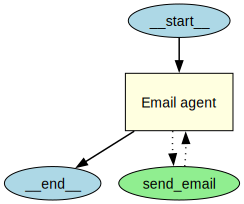

In [13]:
draw_graph(email_agent)

### The next 2 functions write a report and email it

In [14]:
async def write_report(query: str, search_results: list[str]):
    """ Use the writer agent to write a report based on the search results"""
    print("Thinking about report...")
    input = f"Original query: {query}\nSummarized search results: {search_results}"
    result = await Runner.run(writer_agent, input)
    print("Finished writing report")
    return result.final_output

async def send_email(report: ReportData):
    """ Use the email agent to send an email with the report """
    print("Writing email...")
    result = await Runner.run(email_agent, report.markdown_report)
    print("Email sent")
    return report

### Showtime!

In [15]:
query ="Latest updates of the IRS 2024 tax code changes"

with trace("Research trace"):
    print("Starting research...")
    search_plan = await plan_searches(query)
    search_results = await perform_searches(search_plan)
    report = await write_report(query, search_results)
    await send_email(report)  
    print("Hooray!")




Starting research...
Planning searches...
Will perform 3 searches
Searching...
Finished searching
Thinking about report...
Finished writing report
Writing email...
Email sent
Hooray!


### As always, take a look at the trace

https://platform.openai.com/traces

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/thanks.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00cc00;">Congratulations on your progress, and a request</h2>
            <span style="color:#00cc00;">You've reached an important moment with the course; you've created a valuable Agent using one of the latest Agent frameworks. You've upskilled, and unlocked new commercial possibilities. Take a moment to celebrate your success!<br/><br/>Something I should ask you -- my editor would smack me if I didn't mention this. If you're able to rate the course on Udemy, I'd be seriously grateful: it's the most important way that Udemy decides whether to show the course to others and it makes a massive difference.<br/><br/>And another reminder to <a href="https://www.linkedin.com/in/eddonner/">connect with me on LinkedIn</a> if you wish! If you wanted to post about your progress on the course, please tag me and I'll weigh in to increase your exposure.
            </span>
        </td>
    </tr>

In [16]:
from textwrap import dedent
web_search_tools = [
    planner_agent.as_tool(tool_name="plan_searches", tool_description="Plan a set of web searches to perform"),
    search_agent.as_tool(tool_name="search", tool_description="Search the web for information"),
]
web_search_agent = Agent(
    name="WebSearchAgent",
    instructions=dedent(
        """
        You are a web search agent. You will be provided with a query. 
        You should first plan the searches to perform, then perform the searches.
        """
    ),
    tools=web_search_tools,
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"),
)
tools = [
    web_search_agent.as_tool(tool_name="web_search", tool_description="Perform a web search"),
    writer_agent.as_tool(tool_name="write_report", tool_description="Write a detailed report based on the search results"),
    email_agent.as_tool(tool_name="send_email", tool_description="Send an email with the report"),
]

final_agent = Agent(
    name="FinalAgent",
    instructions=dedent(
        """
        You are a manager in a research process. You will always use the tools provided to you to perform the tasks.
        Every tool is specialized for a specific task. 
        You will be provided with a query. You should first plan the searches to perform, then perform the searches,
        then write a report based on the search results, and finally send an email with the report.
        Avoid attachments on the email, and instead use the HTML body of the email to present the report.
        """
    ),
    tools=tools,
    model="gpt-4o-mini",
    model_settings=ModelSettings(tool_choice="required"),
)

In [17]:
message = "Latest latest updates of the IRS 2024 tax code changes"
with trace("Super researcher"):
    result = await Runner.run(final_agent, message)

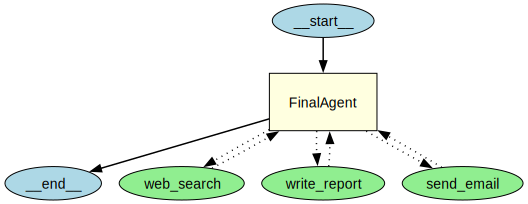

In [18]:
draw_graph(final_agent)